In [ ]:
import mplfinance as mpf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
import pandas as pd
import numpy as np
import requests
import io
import os
import datetime
from concurrent.futures import ThreadPoolExecutor
import json
import urllib.request
import pandas as pd
import ccxt
import os
import gc
# from backtest_module import *

In [51]:
import json
from backtest_module import *
from lightfn_module import *

## Controle Space

In [13]:
# ai_options
Normalization_File= "False"
Model_FileName= "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5"
WINDOW_SIZE= 7
PRESSISION=0.0
PERIODE_START="2023-02-09 00:00:00"
PERIODE_END="2023-02-11 00:00:00"

# start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
# end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')
start_period = pd.Timestamp(PERIODE_START)
end_period = pd.Timestamp(PERIODE_END)


#trading_options:
TAKE_PROFIT= 0.4  
STOP_LOSS=  0.8 
MAX_HOLDING_TIME= 16
PRECISION = 0.0

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
  

## Data space

In [31]:
#################### Files #################

DATABASE_DIR="./database"
INFO_DIR=f"{DATABASE_DIR}/Info"
ALL_BINANCE_TICKERS_LISTFILE=f"{INFO_DIR}/ALL_BINANCE_TICKERS_LISTFILE.json"
ONLY_MY_HALAL_LIST_FILE=f"{INFO_DIR}/ONLY_MY_HALAL_LIST.json"
halal_list_file_path=f"{INFO_DIR}/halal-crypto-list.txt"
BINANCE_KLINES_DATA_DIR=f"{DATABASE_DIR}/OpenBinance/KLINES"
BINANCE_TRADES_DATA_DIR=f"{DATABASE_DIR}/OpenBinance/Trades"
METADATA_FILE=f"{INFO_DIR}/METADATA.csv"
COINGEKO_INFO_FILE=f"{INFO_DIR}/COINGEKO_INFO_FILE.csv"
########### data info ################


In [48]:
def get_my_halal_list(halal_file=halal_list_file_path,ticker_list = ALL_BINANCE_TICKERS):
    
    try:
        with open(ONLY_MY_HALAL_LIST_FILE, "r") as f:
            json.dump(MY_HALA_DIC, f)
        
        VOLATILE_USDT_PAIRS=MY_HALA_DIC["USDT_PAIRS"]
        VOLATILE_BUSD_PAIRS=MY_HALA_DIC["BUSD_PAIRS"]
    except:
    
        ticker_list = ALL_BINANCE_TICKERS
        
        with open(halal_file, "r") as f:
            VOLATILE_COINS = [line.strip() for line in f.readlines()]
        
        VOLATILE_USDT_PAIRS = [f"{coin}/USDT" for coin in VOLATILE_COINS]
        VOLATILE_BUSD_PAIRS = [f"{coin}/BUSD" for coin in VOLATILE_COINS]
        
        # Remove BUSD pairs not listed in Binance
        VOLATILE_BUSD_PAIRS = [pair for pair in VOLATILE_BUSD_PAIRS if pair.replace('/', '') in ticker_list]
        
        # Remove USDT pairs not listed in Binance
        VOLATILE_USDT_PAIRS = [pair for pair in VOLATILE_USDT_PAIRS if pair.replace('/', '') in ticker_list]
        
        # # Remove USDT pairs that don't have 1m data
        # content = os.listdir('database/DataBackTest/1m')
        # VOLATILE_USDT_PAIRS = [pair for pair in VOLATILE_USDT_PAIRS if f"{pair.replace('/', '-')}.csv" in content]
        
        # # Remove BUSD pairs that don't have 1m data
        # VOLATILE_BUSD_PAIRS = [pair for pair in VOLATILE_BUSD_PAIRS if f"{pair.replace('/', '-')}.csv" in content]
    MY_HALA_DIC={"WORKING_PAIRS":VOLATILE_USDT_PAIRS+VOLATILE_BUSD_PAIRS,"VOLATILE_USDT_PAIRS":VOLATILE_USDT_PAIRS,"VOLATILE_BUSD_PAIRS":VOLATILE_BUSD_PAIRS}
    with open(ONLY_MY_HALAL_LIST_FILE, "w") as f:
        json.dump(MY_HALA_DIC, f)
    return VOLATILE_USDT_PAIRS + VOLATILE_BUSD_PAIRS , VOLATILE_USDT_PAIRS ,VOLATILE_BUSD_PAIRS

ALL_BINANCE_TICKERS=get_all_binance_tickers()
ALL_USDT_BUSD_PAIRS=extract_pairs(ALL_BINANCE_TICKERS)
WORKING_PAIRS,VOLATILE_USDT_PAIRS ,VOLATILE_BUSD_PAIRS=get_my_halal_list(halal_file=halal_list_file_path)
MY_HALA_DIC=get_my_halal_list(halal_file=halal_list_file_path)
ALL_CIBLED_COINS = list(set([symbol.split('/')[0].lower() for symbol in ALL_USDT_BUSD_PAIRS] ))


In [56]:

def read_metadata(pairs):
    if not os.path.exists(DATABASE_DIR):
        os.makedirs(DATABASE_DIR)
    try:
        MetaData = pd.read_csv(METADATA_FILE,index_col=0)
        pairs_in_csv = set(MetaData['Pair'].tolist())
        pairs_to_get_metadata = list(set(pairs) - pairs_in_csv)
        if pairs_to_get_metadata:
            new_metadata = get_crypto_metadata(pairs_to_get_metadata)
            MetaData = pd.concat([MetaData, new_metadata], ignore_index=True)
            MetaData.to_csv(METADATA_FILE, index=False)
        return MetaData
    except:
        MetaData = get_crypto_metadata(pairs)
        MetaData.to_csv(METADATA_FILE, index=False)
        return MetaData
MetaData=read_metadata(WORKING_PAIRS)
MetaData

,Pair,launch_week_stamp,launch_day_stamp,launch_minute
0,,,,
LTCUSDT,LTC/USDT,1512950400000,1513123200000,2017-12-13 03:32:00
ARUSDT,AR/USDT,1620604800000,1620950400000,2021-05-14 12:00:00
OPUSDT,OP/USDT,1653868800000,1654041600000,2022-06-01 08:00:00
TRIBEUSDT,TRIBE/USDT,1629676800000,1629763200000,2021-08-24 06:00:00
TVKUSDT,TVK/USDT,1627862400000,1628208000000,2021-08-06 10:00:00
...,...,...,...,...
PYRBUSD,PYR/BUSD,1637539200000,1637884800000,2021-11-26 08:00:00
GALBUSD,GAL/BUSD,1651449600000,1651708800000,2022-05-05 12:00:00
SRMBUSD,SRM/BUSD,1597017600000,1597104000000,2020-08-11 13:30:00


In [57]:
from lightfn_module import *
def get_backtest_historical(exchange, symbol, timeframe, path="database/"):
    symbol = symbol.replace('/','-')
    df = pd.read_csv(filepath_or_buffer=path+"DataBackTest"+"/"+timeframe+"/"+symbol+".csv")
    df = df.set_index(df['date'])
    df.index = pd.to_datetime(df.index, unit='ms')
    del df['date']
    return df


In [58]:
import gc
from collections import defaultdict
from functools import partial
import ccxt

def get_historical_dataframes(working_pairs, oldest_pair="BTC/USDT", timeframes=("1m", "1d", "1h", "5m", "15m"), path="./database/"):
    if oldest_pair not in working_pairs:
        working_pairs.append(oldest_pair)
    
    error_list = []
    dataframes = defaultdict(dict)

    binance = ccxt.binance()
    get_backtest_historical_partial = partial(get_backtest_historical, binance, path=path)

    for pair in working_pairs:
        for tf in timeframes:
            try:
                df = get_backtest_historical_partial(pair, tf)
                dataframes[tf][pair] = df.loc[:]
                del(df)
            except Exception as e:
                print(f" error on {pair} : {e} ")
                error_list.append(pair)
                break

    gc.collect()
    print("Data load 100% use dataframes['1d']['BTC/USDT'] for example to access")
    return dataframes, error_list

dataframes, error_list = get_historical_dataframes(WORKING_PAIRS)


 error on UST/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/UST-USDT.csv' 
 error on BTG/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/BTG-USDT.csv' 
 error on EPS/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/EPS-USDT.csv' 
 error on DNT/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/DNT-USDT.csv' 
 error on UST/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/UST-BUSD.csv' 
 error on BTG/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/BTG-BUSD.csv' 
 error on EPS/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/EPS-BUSD.csv' 
 error on DNT/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/DNT-BUSD.csv' 
Data load 100% use dataframes['1d']['BTC/USDT'] for example to access


In [59]:
pair_list = WORKING_PAIRS
#tf = '1m'
oldest_pair = "BTC/USDT"
if oldest_pair not in pair_list: pair_list.append(oldest_pair)
df_list1m = {}
df_list1d = {}
df_list1h = {}
df_list5m = {}
df_list15m = {}

ERROR_LIST=[]
for pair in pair_list:
    try:
        df = get_backtest_historical(ccxt.binance(), pair, '1m', path="./database/")
        df_list1m[pair] = df.loc[:]

        df = get_backtest_historical(ccxt.binance(), pair, '1d', path="./database/")
        df_list1d[pair] = df.loc[:]

        df = get_backtest_historical(ccxt.binance(), pair, '1h', path="./database/")
        df_list1h[pair] = df.loc[:]

        df = get_backtest_historical(ccxt.binance(), pair, '5m', path="./database/")
        df_list5m[pair] = df.loc[:]

        df = get_backtest_historical(
            ccxt.binance(), pair, '15m', path="./database/")
        df_list15m[pair] = df.loc[:]
        del(df)
        gc.collect()
    except Exception as e:
        print(f" error on {pair} : {e} ")
        ERROR_LIST.append(pair)

df_list = df_list1m
print("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



 error on UST/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/UST-USDT.csv' 
 error on BTG/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/BTG-USDT.csv' 
 error on EPS/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/EPS-USDT.csv' 
 error on DNT/USDT : [Errno 2] No such file or directory: './database/DataBackTest/1m/DNT-USDT.csv' 
 error on UST/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/UST-BUSD.csv' 
 error on BTG/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/BTG-BUSD.csv' 
 error on EPS/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/EPS-BUSD.csv' 
 error on DNT/BUSD : [Errno 2] No such file or directory: './database/DataBackTest/1m/DNT-BUSD.csv' 
Data load 100% use df_list1d["BTC/USDT"] for exemple to access


In [65]:
for ERROR_p in ERROR_LIST: 
    if ERROR_p in WORKING_PAIRS:  WORKING_PAIRS.remove(ERROR_p)

In [67]:
pair_list=WORKING_PAIRS

In [68]:
def get_min_max_dates(dataframes):
    min_start_date = None
    max_end_date = None

    for tf, df_dict in dataframes.items():
        for pair, df in df_dict.items():
            start_date = df.index.min()
            end_date = df.index.max()

            if min_start_date is None or start_date < min_start_date:
                min_start_date = start_date

            if max_end_date is None or end_date > max_end_date:
                max_end_date = end_date

    return min_start_date, max_end_date

min_start_date, max_end_date = get_min_max_dates(dataframes)
print(f"Minimum start date: {min_start_date}")
print(f"Maximum end date: {max_end_date}")


Minimum start date: 2022-11-11 00:00:00
Maximum end date: 2023-02-22 05:18:00


In [69]:
def get_max_min_dates(dataframes):
    max_start_date = None
    min_end_date = None

    for tf, df_dict in dataframes.items():
        for pair, df in df_dict.items():
            start_date = df.index.min()
            end_date = df.index.max()

            if max_start_date is None or start_date > max_start_date:
                max_start_date = start_date

            if min_end_date is None or end_date < min_end_date:
                min_end_date = end_date

    return max_start_date, min_end_date

max_start_date, min_end_date = get_max_min_dates(dataframes)
print(f"Maximum start date: {max_start_date}")
print(f"Minimum end date: {min_end_date}")


Maximum start date: 2022-11-11 00:00:00
Minimum end date: 2022-11-28 00:00:00


In [70]:
start_period=max_start_date
end_period=min_end_date

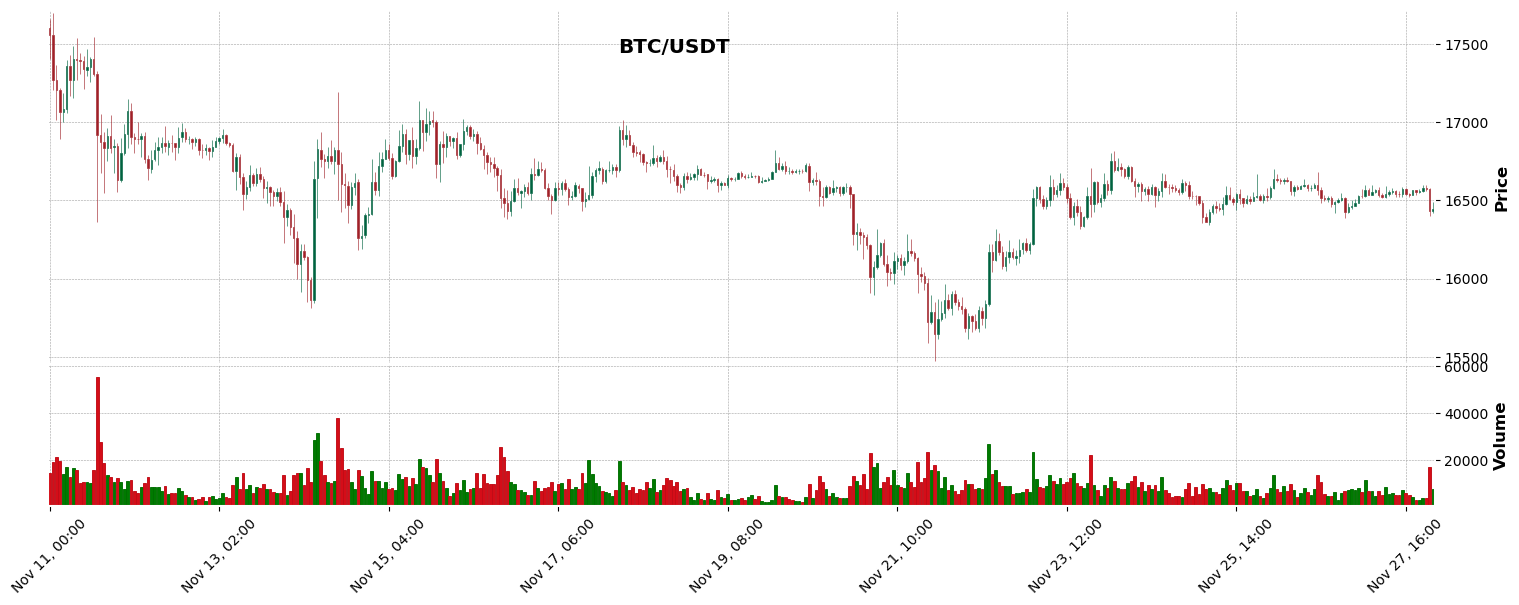

In [72]:
best_testing_pair="BTC/USDT"
plot_ohlcv(df_list1h[best_testing_pair],best_testing_pair, start_date=start_period, end_date=end_period)

In [77]:
def get_top_volumes(start_period,end_period,df_list1d=df_list1d):
    ALLTOP20VOLUMES={}
    for day in df_list1d["BTC/USDT"].index:
        if start_period<= day <= end_period:
            Top20vol={}
            for p,df in df_list1d.items():
                if p not in ["EUR/USDT","EUR/BUSD","BTC/USDT","BTC/BUSD"]:
                    try:Top20vol.update({p:(df.loc[day].volume*df.loc[day].close)})
                    except Exception as e :pdebug(f'Time Error wile working on {p}: {e}')
                    #print (Top20vol)
            ALLTOP20VOLUMES.update({day:sorted(Top20vol, key=Top20vol.get, reverse=True)[:20]})
    return ALLTOP20VOLUMES

def is_coin_in_portfolio(symbol,instant,PORTFOLIO):
    for i in range(1,TRADE_SLOTS+1):
        try:
            if (PORTFOLIO[f"slot{i}_symbol"].loc[instant]==symbol):
                return i
        except Exception as e:
            print(f"error :{e}")
    return False
ALLTOP20VOLUMES=get_top_volumes(start_period-pd.Timedelta("10 minute") ,end_period+pd.Timedelta("10 minute"))


In [85]:
SORT_SIGNAL=True
def backtest_buy_sell(SIGNAL_DF, df_list1m, start_period, end_period):
    pdebug(f"---   Backtesting form {start_period} to {end_period} while tp:{TAKE_PROFIT}% and sl:{STOP_LOSS}% and trading fee: {TRADING_FEE}% --- ")
    # Initialize variables and counters
    global ORDER_HISTORY 
    ORDER_HISTORY = pd.DataFrame(columns=['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
    current_time = pd.Timestamp(start_period)
    end_period_margin = end_period + pd.Timedelta(f"{2 * MAX_HOLDING_TIME} minute")
    PORTFOLIO = create_portfolio_dataframe(TRADE_SLOTS, init_quantity=550, base_currency=PAIR_WITH, PERIODE_START=start_period)
    PeriodRange = pd.date_range(start=pd.Timestamp(start_period), end=pd.Timestamp(end_period), freq='1min')

    # Verify buying opportunities
    for current_time in PeriodRange:
        if current_time == pd.Timestamp(start_period):
            pdebug(f"update_slots -> The first case : {current_time}")
            PORTFOLIO.loc[current_time + pd.Timedelta("1 minute")] =PORTFOLIO.loc[current_time]
            continue
        else:
            previous_minute = current_time - pd.Timedelta("1 minute")
        # print(PORTFOLIO.tail)
        PORTFOLIO=update_slots(current_time, df_list1m, PORTFOLIO=PORTFOLIO)
        pdebug(current_time)
        if SORT_SIGNAL:
            minute_signal_list=SIGNAL_DF[SIGNAL_DF.time == pd.Timestamp(current_time)].sort_values('note',ascending=False)
        else:
            minute_signal_list=SIGNAL_DF[SIGNAL_DF.time == pd.Timestamp(current_time)]
        for i, sig_row in minute_signal_list.iterrows():
            # Buy the coin if slot and cash is available:
            coin = sig_row['coin']
            time = sig_row['time']
            price = sig_row['price']  # We assume there's only one price per signal
            note = sig_row['note']
            slot_num = is_coin_in_portfolio(coin, previous_minute, PORTFOLIO)

            # Buy first:
            if (note + PRECISION) >= 0.5:
                PORTFOLIO = buy_coin(time, coin, price, PORTFOLIO=PORTFOLIO, pair_with_qte=TRADE_TOTAL)

        if USE_TRAILING_STOP_LOSS:
            PORTFOLIO = trailing_stop_loss_take_profit(current_time, PORTFOLIO, TAKE_PROFIT, STOP_LOSS, TRAILING_STOP_LOSS, TRAILING_TAKE_PROFIT)
        else:
            PORTFOLIO = stop_loss_or_take_profit(current_time, df_list1m, PORTFOLIO, STOP_LOSS, TAKE_PROFIT, TRADING_FEE)
        PORTFOLIO = stop_holding(current_time, PORTFOLIO, MAX_HOLDING_TIME)
        pct_benefit = 100 * PORTFOLIO.at[current_time, f'total_{PAIR_WITH}'] / PORTFOLIO[f'total_{PAIR_WITH}'].iloc[0]
        pdebug(f"Total benefit pct {pct_benefit}")
        
    return PORTFOLIO



In [140]:

def day_expand(data_full):
    ser = pd.to_datetime(pd.Series(data_full.index))
    data_full["day"]=ser.dt.isocalendar().day.values
    data_full["hour"]=ser.dt.hour.values
    data_full["minute"]=ser.dt.minute.values
    

def Meta_expand(data_full,metadt,pair):
    data_full["lunch_day"]=int(-(pd.to_datetime(metadt[metadt["Pair"] == pair]["launch_minute"])-pd.Timestamp('2020-01-01 00:00:00.000000')).dt.days)


def expand_previous_v0(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        for i in range(1, window+1):
            df.loc[window:len(df),"high-"+str(i)]=None
            df.loc[window:len(df),"low-"+str(i)]=None
            df.loc[window:len(df),"close-"+str(i)]=None            
            df.loc[window:len(df),"volume-"+str(i)]=None
        window=len(df)

    for i in range(1, window+1):
        try:
            df.loc[window:len(df),"high-"+str(i)]=None
            df["high-"+str(i)].iloc[window:len(df)]=df["high"][window-i:len(df)-i].to_list()
            df.loc[window:len(df),"low-"+str(i)]=None
            df["low-"+str(i)].iloc[window:len(df)]=df["low"][window-i:len(df)-i].to_list()
            df.loc[window:len(df),"close-"+str(i)]=None
            df["close-"+str(i)].iloc[window:len(df)]=df["close"][window-i:len(df)-i].to_list()            
            df.loc[window:len(df),"volume-"+str(i)]=None
            df["volume-"+str(i)].iloc[window:len(df)]=df["volume"][window-i:len(df)-i].to_list()
            
        except:
            prerr("Error in     expand_previous: " +str(i))
    if window >= len(df): return df       
    return df.iloc[window:]

def expand_previous(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        for i in range(1, window+1):
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=None            
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=None
        window=len(df)

    for i in range(1, window+1):
        try:
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("high-"+str(i))]=df["high"][window-i:len(df)-i].to_list()
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("low-"+str(i))]=df["low"][window-i:len(df)-i].to_list()
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("close-"+str(i))]=df["close"][window-i:len(df)-i].to_list()            
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=None
            df.iloc[window:, df.columns.get_loc("volume-"+str(i))]=df["volume"][window-i:len(df)-i].to_list()
            
        except:
            prerr("Error in     expand_previous: " +str(i))
    if window >= len(df): return df       
    return df.iloc[window:]


def expand_previous_v2(dataframe, window=10):
    df = dataframe.copy()
    if window >= len(df):
        df = df.reindex(columns=[col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]])
        return df

    window_cols = df[["high", "low", "close", "volume"]].rolling(window, min_periods=1)
    window_cols = window_cols.apply(lambda x: pd.Series(x.values))
    window_cols.columns = [col+"-"+str(i) for i in range(1, window+1) for col in ["high", "low", "close", "volume"]]
    df = pd.concat([df, window_cols], axis=1)
    df = df.iloc[window:]
    return df

def rapid1d_expand(df1m,df1d,window=2):
    d1min=df1m.copy()
    d1day=df1d.loc[
    d1min.index[0].round(freq='1d')-pd.Timedelta(str(window)+' day'):
    d1min.index[len(d1min)-1].round(freq='1d')+pd.Timedelta('1 day')
    ].copy()
    d1day_pre=expand_previous(d1day,window)
    d1day_pre=d1day_pre.drop(columns=['open', 'low','close','high','volume'])
    d1day_pre=d1day_pre.add_suffix("_day")
    d1min=pd.merge_asof(
        d1min, d1day_pre, on=None, left_on=None, right_on=None, left_index=True, 
        right_index=True, by=None, left_by=None, right_by=None, 
        suffixes=('', '_day'),
        tolerance=pd.Timedelta('1 day'), allow_exact_matches=True, direction='backward')
    return d1min

def rapid1h_expand(df1m,df1h,window=2):
    d1min=df1m.copy()
    d1hour=df1h.loc[
    d1min.index[0].round(freq='H')-pd.Timedelta(str(window)+' hour'):
    d1min.index[len(d1min)-1].round(freq='H')+pd.Timedelta('1 hour')
    ].copy()
    d1hour_pre=expand_previous(d1hour,window)
    d1hour_pre=d1hour_pre.drop(columns=['open', 'low','close','high','volume'])
    d1hour_pre=d1hour_pre.add_suffix("_hour")
    d1min=pd.merge_asof(
    d1min, d1hour_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_hour'),
    tolerance=pd.Timedelta('1 hour'), allow_exact_matches=True, direction='backward')
    return d1min


def rapid5m_expand(df1m,df5m,window=2):
    d1min=df1m.copy()
    d5min=df5m.loc[
    d1min.index[0].round(freq='5 min')-pd.Timedelta(str(window*5+10)+' min'):
    d1min.index[len(d1min)-1].round(freq='5 min')+pd.Timedelta('5 min')
    ].copy()
    d5min_pre=expand_previous(d5min,window)
    d5min_pre=d5min_pre.drop(columns=['open', 'low','close','high','volume'])
    d5min_pre=d5min_pre.add_suffix("_5min")
    d1min=pd.merge_asof(
    d1min, d5min_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_5min'),
    tolerance=pd.Timedelta('5 min'), allow_exact_matches=True, direction='backward')
    return d1min

def rapid15m_expand(df1m,df15m,window=2):
    d1min=df1m.copy()
    d15min=df15m.loc[
    d1min.index[0].round(freq='15 min')-pd.Timedelta(str(window*15+30)+' min'):
    d1min.index[len(d1min)-1].round(freq='15 min')+pd.Timedelta('15 min')
    ].copy()
    d15min_pre=expand_previous(d15min,window)
    d15min_pre=d15min_pre.drop(columns=['open', 'low','close','high','volume'])
    d15min_pre=d15min_pre.add_suffix("_15min")
    d1min=pd.merge_asof(
    d1min, d15min_pre, on=None, left_on=None, right_on=None, left_index=True, 
    right_index=True, by=None, left_by=None, right_by=None, 
    suffixes=('', '_15min'),
    tolerance=pd.Timedelta('15 min'), allow_exact_matches=True, direction='backward')
    return d1min


def full_expand(df1m,df5m,df15m,df1h,df1d,window=10):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=window).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,window)
    d1min=rapid1h_expand(d1min,df1h,window)
    d1min=rapid15m_expand(d1min,df15m,window)
    d1min=rapid5m_expand(d1min,df5m,window)
    return d1min

def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min



        

def full_expand_costum(df1m,df5m,df15m,df1h,df1d,w1m=10,w5m=30,w15m=30,w1h=3,w1d=7):
    d1min=df1m.copy()
    d1min=expand_previous(d1min,window=w1m).drop(columns=["volume"])
    d1min=rapid1d_expand(d1min,df1d,w1d)
    d1min=rapid1h_expand(d1min,df1h,w1h)
    d1min=rapid15m_expand(d1min,df15m,w15m)
    d1min=rapid5m_expand(d1min,df5m,w5m)
    return d1min

def maxi_expand_v3(pair="GMT/USDT", i=0, j=10000, TIME_WINDOW=15, metadata=MetaData,
                 high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                 buy_function=buy_alwase,
                 w1m=6,w5m=30,w15m=30,w1h=3,w1d=7,
                 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=30,btc_w1d=30,
                 df_list1m=df_list1m,df_list5m=df_list5m, df_list15m=df_list15m, df_list1h=df_list1h, df_list1d=df_list1d
                 ):
    start_index=i
    end_index=j
    window=TIME_WINDOW
    window_size=window
    buy_fn=buy_function

    print(f"maxi custum expend : {pair} with those parameters: w1m={w1m},w5m={w5m},w15m={w15m},w1h={w1h},w1d={w1d} btc_w1m={btc_w1m},btc_w5m={btc_w5m},btc_w15m={btc_w15m},btc_w1h={btc_w1h},btc_w1d={btc_w1d}")
    # Select data
    pair_df = df_list1m[pair].iloc[start_index:end_index]
    btc_df = df_list1m["BTC/USDT"].loc[(pair_df.index[0] - pd.DateOffset(days=window_size+1)).round(freq='1 min'):pair_df.index[-1]+pd.Timedelta(f"{window_size} day")]
    # Calculate technical indicators
    pair_full = full_expand_costum(pair_df, df_list5m[pair], df_list15m[pair], df_list1h[pair], df_list1d[pair],w1m=w1m,w5m=w5m,w15m=w15m,w1h=w1h,w1d=w1d)
    btc_full = full_expand_costum(btc_df, df_list5m["BTC/USDT"], df_list15m["BTC/USDT"], df_list1h["BTC/USDT"], df_list1d["BTC/USDT"], w1m=btc_w1m,w5m=btc_w5m,w15m=btc_w15m,w1h=btc_w1h,w1d=btc_w1d)   
    btc_full = btc_full.add_prefix("BTC_")
    merged = pd.merge(pair_full, btc_full, left_index=True, right_index=True)
    day_expand(merged)
    Meta_expand(merged, metadata, pair)
    print(merged.columns)
    merged = buy_fn(merged, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT, window=TIME_WINDOW)
    merged["high"] = (merged["open"] + high_weight * merged["high"] + merged["low"] + merged["close"]) / (3 + high_weight)
    merged["BTC_high"] = (merged["BTC_open"] + high_weight * merged["BTC_high"] + merged["BTC_low"] + merged["BTC_close"]) / (3 + high_weight)
    merged.rename(columns={"high":"price"},inplace=True)
    merged.rename(columns={"BTC_high":"BTC_price"},inplace=True)
    merged = merged.drop(columns=["BTC_open","BTC_low","BTC_close","open","low","close"]) 
    for key in merged.keys():
        if key.find("BTC")!=-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=1-(merged[key])/merged["BTC_price"]
        if key.find("BTC")==-1 and (key.find("open")!=-1 or
    key.find("high")!=-1 or key.find("low")!=-1 or key.find("close")!=-1):
            merged[key]=1-(merged[key])/merged["price"]

    merged=merged.dropna()
    print(f'######################  max expend {pair} - shape {merged.shape}  buy mean : {hp(merged.buy.mean())} ############################')
    return merged

def human_pct(float_pct,type_string="Precent Mean",ShowMessage=True):
    nb=round(float_pct*100,3)
    if ShowMessage: print(type_string+": "+"{:.3f}".format(nb)+"%")
    return nb
hp=human_pct


import warnings
warnings.filterwarnings('ignore')
PRERR=False
def prerr(err):
    if PRERR:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

PDEBUG=True
def pdebug(err):
    if PDEBUG:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))
        
        

In [82]:
tests_history = pd.DataFrame(columns=['Model-FileName', 'TAKE_PROFIT', 'STOP_LOSS', 'MAX_HOLDING_TIME', 'FinalValue', 'Profit', 'ROI', 'Nbr_wins', 'best_win', 'worst_loss'])
noww=pd.Timestamp(datetime.now())
tests_history_filename=f"workdir/backtest/test_all_models_tp{STOP_LOSS}_sl{TAKE_PROFIT}_mht{MAX_HOLDING_TIME}_between__{start_period}--{end_period}____{noww}.csv"

In [ ]:
Mini_ALLTOP20VOLUMES={pd.Timestamp('2022-11-11 00:00:00'): ['SOL/USDT',
  'DOGE/USDT',
  'XRP/USDT',
  'SOL/BUSD',
  'LTC/USDT',
  'DOGE/BUSD',
  'XRP/BUSD',
  'ADA/USDT',
  'SHIB/USDT',
  'DOT/USDT',
  'AVAX/USDT',
  'OP/USDT',
  'TRX/USDT',
  'APE/USDT',
  'ETC/USDT',
  'NEAR/USDT',
  'ALGO/USDT',
  'GALA/USDT',
  'ADA/BUSD',
  'LTC/BUSD'],
 pd.Timestamp('2022-11-12 00:00:00'): ['DOGE/USDT',
  'DOGE/BUSD',
  'SOL/USDT',
  'XRP/USDT',
  'SOL/BUSD',
  'SHIB/USDT',
  'LTC/USDT',
  'NEAR/USDT',
  'XRP/BUSD',
  'ADA/USDT',
  'TRX/USDT',
  'NEAR/BUSD',
  'APE/USDT',
  'SHIB/BUSD',
  'DOT/USDT',
  'AVAX/USDT',
  'ADA/BUSD',
  'ALGO/USDT',
  'LUNA/USDT',
  'LUNA/BUSD'],
 pd.Timestamp('2022-11-13 00:00:00'): ['DOGE/USDT',
  'XRP/USDT',
  'AXS/USDT',
  'SOL/USDT',
  'DOGE/BUSD',
  'SOL/BUSD',
  'TRX/USDT',
  'ADA/USDT',
  'SHIB/USDT',
  'XRP/BUSD',
  'LTC/USDT',
  'NEAR/USDT',
  'DOT/USDT',
  'GMT/USDT',
  'APE/USDT',
  'AXS/BUSD',
  'AVAX/USDT',
  'OP/USDT',
  'ALGO/USDT',
  'WAVES/USDT']}


In [141]:
day=pd.Timestamp("2022-11-11")
coin="SOL/USDT"
loc_start = df_list1m[coin].index.get_loc(day)
loc_end = df_list1m[coin].index.get_loc(day+pd.Timedelta('1 day'))
mini_df=maxi_expand_v3(pair=coin, i=loc_start, j=loc_end, TIME_WINDOW=3, metadata=MetaData,
                                    high_weight=1, BUY_PCT=BUY_PCT, SELL_PCT=SELL_PCT,
                                    buy_function=buy_alwase,
                                    w1m=6,w5m=10,w15m=25,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15,
                           df_list1m=df_list1m,df_list5m=df_list5m, df_list15m=df_list15m, df_list1h=df_list1h, df_list1d=df_list1d)

maxi custum expend : SOL/USDT with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15


KeyError: 'high-1'

In [133]:
mini_df

,price,high-1,low-1,close-1,volume-1,high-2,low-2,close-2,volume-2,high-3,...,BTC_volume-3_5min,BTC_high-4_5min,BTC_low-4_5min,BTC_close-4_5min,BTC_volume-4_5min,day,hour,minute,lunch_day,buy
date,,,,,,,,,,,,,,,,,,,,,


In [ ]:
SIGNAL_DF = generate_signals_costum(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=25,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)

Testing model: /UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_VeryDeep.h5 
maxi custum expend : SOL/USDT with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : DOGE/USDT with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : XRP/USDT with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : SOL/BUSD with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : LTC/USDT with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : DOGE/BUSD with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w1d=7 btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15
maxi custum expend : XRP/BUSD with those parameters: w1m=6,w5m=10,w15m=25,w1h=8,w

/UltimeTradingBot/Crypto_backtest_tools/backtest_module.py:206: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data[f'slot{i+1}_bought_time'] = None
/UltimeTradingBot/Crypto_backtest_tools/backtest_module.py:209: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.set_index('date', inplace=True)
/UltimeTradingBot/Crypto_backtest_tools/backtest_module.py:206: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data[f'slot{i+1}_bought_time'] = None
/UltimeTradingBot/Crypto_backtest_tools/backtest_module.py:209: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values in

Initial Investment: 550.00 USDT
Final Value: 550.00 USDT
Profit: 0.00 USDT
Return on Investment (ROI): 0.00%


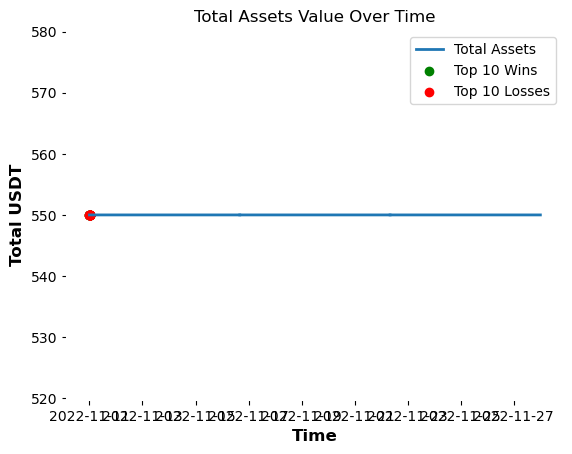

ZeroDivisionError: division by zero

In [90]:
ORDER_HISTORY= pd.DataFrame(columns= ['Order ID', 'Pair', 'Side', 'Price', 'Quantity', 'Executed', 'Time', 'Status'])
Model_FileName="/UltimeTradingBot/Data/IS_MIN/tp100_w15_max15min_Model_VeryDeep.h5"
model_file=Model_FileName
print(f"Testing model: {model_file} ")
backtest_model=load_model(Model_FileName)
SIGNAL_DF = generate_signals_costum(ALLTOP20VOLUMES, df_list1m, WINDOW_SIZE, MetaData, TAKE_PROFIT, STOP_LOSS, backtest_model,w1m=6,w5m=10,w15m=25,w1h=8,w1d=7,
                           btc_w1m=6,btc_w5m=4,btc_w15m=5,btc_w1h=12,btc_w1d=15)
USE_TRAILING_STOP_LOSS= False

TRAILING_DATA=pd.DataFrame()
PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
PORTFOLIO=backtest_buy_sell(SIGNAL_DF, df_list1m, start_period=start_period, end_period=end_period)
back_test_metrics(PORTFOLIO)
metrics=get_back_test_metrics(PORTFOLIO)
win,loss=calculate_wins_losses(ORDER_HISTORY)

# model_results = test_single_model(model_file, start_period, end_period, window_size, take_profit, stop_loss, max_holding_time, precision, use_trailing_stop_loss, trailing_stop_loss, trailing_take_profit)
# tests_history = tests_history.append(model_results, ignore_index=True)
# tests_history.to_csv(tests_history_filename)